## Data Setup

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import zipfile
import numpy as np
from geopy.distance import geodesic
import matplotlib.pyplot as plt
from datetime import timedelta
import os
import requests
import pandas as pd
from scipy.stats import mode
from pandas.tseries.holiday import USFederalHolidayCalendar
from datetime import timedelta
from sklearn.metrics.pairwise import haversine_distances
from math import radians
from scipy.sparse import lil_matrix, coo_matrix, csr_matrix
import pickle
from collections import defaultdict
from scipy.sparse import dok_matrix

In [ ]:
id_map = {}
# Show all rows
pd.set_option('display.max_rows', None)

# Show all columns
pd.set_option('display.max_columns', None)

# Prevent wide columns from being truncated
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
np.set_printoptions(threshold=np.inf)

## Data Preprocessing
Removing null values, mapping each station to a unique integer ID, plotting a histogram to visualize demand across a day

### Load in the data (first run)
Note that we loaded the data into .pkl files in four month increments (Jan-Apr, May-Aug, Sept-Dec), since loading in all the data in one go caused the RAM to crash.

In [ ]:
def read_citibike_zip(zip_path):
    print("Reading zipfile" + zip_path)
    file_name = zip_path.replace('.csv', '').replace('.zip', '').replace('data/', '')
    print("Filename: " + file_name)

    df = None

    with zipfile.ZipFile(zip_path, 'r') as z:
        print(z.namelist())
        # csv_name = z.namelist()[0]  # assumes one CSV per zip
        # with z.open(csv_name) as f:
        #     df = pd.read_csv(f)
        csv_files = [name for name in z.namelist() if name.endswith('.csv')]
        dfs = []

        for csv_name in csv_files:
            print("csv_name:", csv_name)
            with z.open(csv_name) as f:
                try:
                    df_part = pd.read_csv(f)
                    dfs.append(df_part)
                except:
                    print(f"Error. Skipping file: {csv_name}")

        # Combine all into a single DataFrame
        df = pd.concat(dfs, ignore_index=True)


    df = df.rename(columns={
        'start_station_id': 'start_id',
        'start_lat': 'start_lat',
        'start_lng': 'start_lng',
        'end_station_id': 'end_id',
        'end_lat': 'end_lat',
        'end_lng': 'end_lng'
    })

    print("df.columns:", df.columns)
    print("df.shape:", df.shape)

    # 1. REMOVE NULL VALUES
    df.replace(['nan', 'NaN', ''], np.nan, inplace=True)
    df.dropna(inplace=True)
    df['started_at'] = pd.to_datetime(df['started_at'], errors='coerce')
    df = df.dropna(subset=['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'], errors='coerce')
    df = df.dropna(subset=['ended_at'])

    # 2. Convert all start_ids, end_ids to strings (so that unique_ids like 6501.23 and '6501.23' are counted as the same value)
    # want to map station ids to some nice integer value 0 to N_station - 1
    df['start_id'] = df['start_id'].astype(str)
    df['end_id'] = df['end_id'].astype(str)

    unique_ids = pd.unique(pd.concat([df['start_id'], df['end_id']]))
    for station_id in pd.unique(pd.concat([df['start_id'], df['end_id']])):
        if station_id not in id_map:
            id_map[station_id] = len(id_map)
    print("unique_ids.shape", unique_ids.shape)
    df['start_id'] = df['start_id'].map(id_map)
    df['end_id'] = df['end_id'].map(id_map)

    # 2.5. Sample 20 points to double check that the data looks ok
    sample_df = df.sample(n=20, random_state=42)
    print("\nRandom Sample of 20 Rows:")
    print(sample_df[['start_station_name', 'start_id', 'end_station_name', 'end_id']])

    # 3. Plot histogram to determine what hours of the day have the most amount of bike trips
    # Categories: 1-2, 2-3, ..., 12-13, 13-14, ..., 21-22, 23-00
    # 3. Plot histogram to determine what hours of the day have the most bike trips
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['start_hour'] = df['started_at'].dt.hour

    plt.figure(figsize=(12, 6))
    plt.hist(df['start_hour'], bins=24, range=(0, 24), edgecolor='black', align='left')
    plt.xticks(range(24))
    plt.xlabel('Hour of Day')
    plt.ylabel('Number of Trips')
    plt.title('Number of Bike Trips by Hour of Day')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    plt.close()

    return df

#### Read the data

Reading zipfilegdrive/My Drive/CS 190A/ZIP DATA/202401-citibike-tripdata.csv.zip
Filename: gdrive/My Drive/CS 190A/ZIP DATA/202401-citibike-tripdata
['202401-citibike-tripdata.csv', '__MACOSX/._202401-citibike-tripdata.csv']
csv_name: 202401-citibike-tripdata.csv


<ipython-input-5-014e68da92d4>:20: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_part = pd.read_csv(f)


csv_name: __MACOSX/._202401-citibike-tripdata.csv
Error. Skipping file: __MACOSX/._202401-citibike-tripdata.csv
df.columns: Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_id', 'end_station_name', 'end_id',
       'start_lat', 'start_lng', 'end_lat', 'end_lng', 'member_casual'],
      dtype='object')
df.shape: (1888085, 13)
unique_ids.shape (2262,)

Random Sample of 20 Rows:
                          start_station_name  start_id  \
671910          Lafayette Ave & Ft Greene Pl      1332   
1505045               Hanson Pl & Ashland Pl      1082   
1688991             Cauldwell Ave & E 158 St       785   
23877                Wyckoff Ave & Gates Ave        10   
1558727              E 44 St & Lexington Ave      2132   
1118906  Adam Clayton Powell Blvd & W 132 St      1459   
1099207               Irving Ave & Harman St       155   
138772                       E 27 St & 1 Ave       717   
1152227               E 128 St & Madison Ave      1

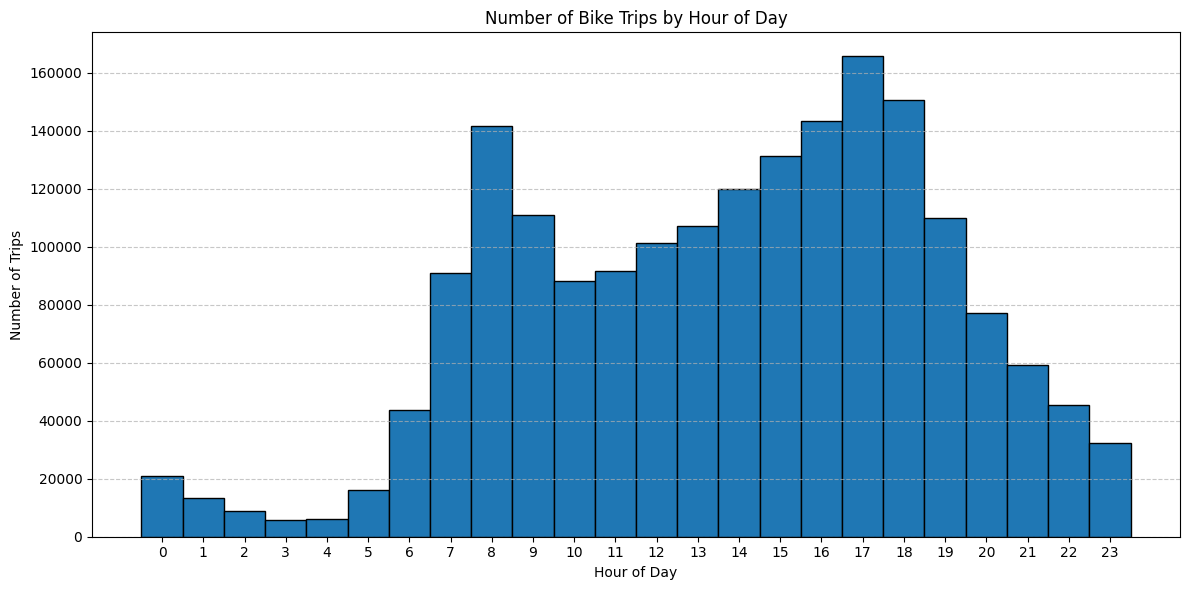

In [ ]:
ZIP_FILES = [
    "gdrive/My Drive/CS 190A/ZIP DATA/202401-citibike-tripdata.csv.zip"
    # "gdrive/My Drive/CS 190A/ZIP DATA/202402-citibike-tripdata.csv.zip",
    # "gdrive/My Drive/CS 190A/ZIP DATA/202403-citibike-tripdata.csv.zip",
    # "gdrive/My Drive/CS 190A/ZIP DATA/202404-citibike-tripdata.csv.zip",
    # "gdrive/My Drive/CS 190A/ZIP DATA/202405-citibike-tripdata.zip",
    # "gdrive/My Drive/CS 190A/ZIP DATA/202406-citibike-tripdata.zip",
    # "gdrive/My Drive/CS 190A/ZIP DATA/202407-citibike-tripdata.zip",
    # "gdrive/My Drive/CS 190A/ZIP DATA/202408-citibike-tripdata.zip",
    # "gdrive/My Drive/CS 190A/ZIP DATA/202409-citibike-tripdata.zip",
    # "gdrive/My Drive/CS 190A/ZIP DATA/202410-citibike-tripdata.zip",
    # "gdrive/My Drive/CS 190A/ZIP DATA/202411-citibike-tripdata.zip",
    # "gdrive/My Drive/CS 190A/ZIP DATA/202412-citibike-tripdata.zip"
]

all_dfs = []
for zip_file in ZIP_FILES:
    zip_path = zip_file
    df = read_citibike_zip(zip_path)
    if not df.empty:
        all_dfs.append(df)

In [ ]:
if all_dfs:
    full_df = pd.concat(all_dfs, ignore_index=True)

else:
  print("No data was loaded from the zip files")

In [ ]:
full_df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_id,end_station_name,end_id,start_lat,start_lng,end_lat,end_lng,member_casual,start_hour
0,5078F3D302000BD2,electric_bike,2024-01-22 18:43:19.012,2024-01-22 18:48:10.708,Frederick Douglass Blvd & W 145 St,0,St Nicholas Ave & W 126 St,174,40.823072,-73.941738,40.811432,-73.951878,member,18
1,814337105D37302A,electric_bike,2024-01-11 19:19:18.721,2024-01-11 19:47:36.007,W 54 St & 6 Ave,1,E 74 St & 1 Ave,178,40.761822,-73.977036,40.768974,-73.954823,member,19
2,A33A920E2B10710C,electric_bike,2024-01-30 19:17:41.693,2024-01-30 19:32:49.857,E 11 St & Ave B,2,W 10 St & Washington St,168,40.727592,-73.979751,40.733424,-74.008515,casual,19
3,A3A5FC0DD7D34D74,electric_bike,2024-01-27 11:27:01.759,2024-01-27 11:38:01.213,W 54 St & 6 Ave,1,E 74 St & 1 Ave,178,40.761779,-73.977144,40.768974,-73.954823,member,11
4,6F96728ECEFBDAA4,electric_bike,2024-01-16 15:15:41.000,2024-01-16 15:29:26.156,Madison Ave & E 99 St,3,E 74 St & 1 Ave,178,40.789808,-73.952214,40.768974,-73.954823,member,15


Save the dataframe

In [ ]:
full_df.to_pickle('gdrive/My Drive/CS 190A/dataframes/full_df.pkl')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load in the data (after the first run)
Combine dataframes across 4-month periods

In [ ]:
full_df = pd.read_pickle('gdrive/My Drive/CS 190A/dataframes/may_aug.pkl')

In [ ]:
full_df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_id,end_station_name,end_id,start_lat,start_lng,end_lat,end_lng,member_casual,start_hour,Unnamed: 0,rideable_type_duplicate_column_name_1
0,FE6A074FC945A086,electric_bike,2024-05-01 08:05:53,2024-05-01 08:15:14,1 Ave & E 30 St,0,E 74 St & 1 Ave,116,40.741509,-73.975355,40.768974,-73.954823,member,8,NaN,NaN
1,6844CF42F72827D7,classic_bike,2024-05-10 15:00:06,2024-05-10 15:08:58,31 Ave & 57 St,1,31 Ave & Steinway St,1139,40.757357,-73.904726,40.761149,-73.917007,member,15,NaN,NaN
2,D7C9E007F791A7A2,classic_bike,2024-05-06 12:28:39,2024-05-06 12:35:21,E 89 St & 3 Ave,2,E 80 St & 2 Ave,372,40.780628,-73.952167,40.773914,-73.954395,member,12,NaN,NaN
3,3419650E2F5999F1,classic_bike,2024-05-16 16:09:14,2024-05-16 16:14:20,E 89 St & 3 Ave,2,E 80 St & 2 Ave,372,40.780628,-73.952167,40.773914,-73.954395,member,16,NaN,NaN
4,5469FDC75E0F1FCA,electric_bike,2024-05-29 15:43:37,2024-05-29 15:49:27,1 Ave & E 30 St,0,E 45 St & 3 Ave,382,40.741444,-73.975361,40.752554,-73.972826,member,15,NaN,NaN


Also, we need to read in the station id mapping.

In [ ]:
with open('gdrive/My Drive/CS 190A/dataframes/id_map.pkl', 'rb') as f:
    id_map = pickle.load(f)

In [ ]:
full_df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_id,end_station_name,end_id,start_lat,start_lng,end_lat,end_lng,member_casual,start_hour,Unnamed: 0,rideable_type_duplicate_column_name_1
0,FE6A074FC945A086,electric_bike,2024-05-01 08:05:53,2024-05-01 08:15:14,1 Ave & E 30 St,0,E 74 St & 1 Ave,116,40.741509,-73.975355,40.768974,-73.954823,member,8,NaN,NaN
1,6844CF42F72827D7,classic_bike,2024-05-10 15:00:06,2024-05-10 15:08:58,31 Ave & 57 St,1,31 Ave & Steinway St,1139,40.757357,-73.904726,40.761149,-73.917007,member,15,NaN,NaN
2,D7C9E007F791A7A2,classic_bike,2024-05-06 12:28:39,2024-05-06 12:35:21,E 89 St & 3 Ave,2,E 80 St & 2 Ave,372,40.780628,-73.952167,40.773914,-73.954395,member,12,NaN,NaN
3,3419650E2F5999F1,classic_bike,2024-05-16 16:09:14,2024-05-16 16:14:20,E 89 St & 3 Ave,2,E 80 St & 2 Ave,372,40.780628,-73.952167,40.773914,-73.954395,member,16,NaN,NaN
4,5469FDC75E0F1FCA,electric_bike,2024-05-29 15:43:37,2024-05-29 15:49:27,1 Ave & E 30 St,0,E 45 St & 3 Ave,382,40.741444,-73.975361,40.752554,-73.972826,member,15,NaN,NaN


## Splitting the Data
Split the data into training and testing datasets. This also involves creating time and weather features for each time step, as well as inflow and outflow values for each time step (these are our model's target values)

We first define the parameters used to split the dataset, including the length of each interval in the dataset (`time_granularity`), as well as how much data we use for each of the training and testing sets (`X_interval` and `y_interval`).

In [ ]:
start_time = full_df['started_at'].min()
end_time = full_df['started_at'].max()
X_interval = timedelta(hours=12)
y_interval = timedelta(hours=3)
time_granularity = timedelta(hours=1)

We then group the data into four hour time bins, as this is our granularity

In [ ]:
full_df['time_bin'] = full_df['started_at'].dt.floor('1h')

In [ ]:
full_df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_id,end_station_name,end_id,start_lat,start_lng,end_lat,end_lng,member_casual,start_hour,Unnamed: 0,rideable_type_duplicate_column_name_1,time_bin
0,FE6A074FC945A086,electric_bike,2024-05-01 08:05:53,2024-05-01 08:15:14,1 Ave & E 30 St,0,E 74 St & 1 Ave,116,40.741509,-73.975355,40.768974,-73.954823,member,8,NaN,NaN,2024-05-01 08:00:00
1,6844CF42F72827D7,classic_bike,2024-05-10 15:00:06,2024-05-10 15:08:58,31 Ave & 57 St,1,31 Ave & Steinway St,1139,40.757357,-73.904726,40.761149,-73.917007,member,15,NaN,NaN,2024-05-10 15:00:00
2,D7C9E007F791A7A2,classic_bike,2024-05-06 12:28:39,2024-05-06 12:35:21,E 89 St & 3 Ave,2,E 80 St & 2 Ave,372,40.780628,-73.952167,40.773914,-73.954395,member,12,NaN,NaN,2024-05-06 12:00:00
3,3419650E2F5999F1,classic_bike,2024-05-16 16:09:14,2024-05-16 16:14:20,E 89 St & 3 Ave,2,E 80 St & 2 Ave,372,40.780628,-73.952167,40.773914,-73.954395,member,16,NaN,NaN,2024-05-16 16:00:00
4,5469FDC75E0F1FCA,electric_bike,2024-05-29 15:43:37,2024-05-29 15:49:27,1 Ave & E 30 St,0,E 45 St & 3 Ave,382,40.741444,-73.975361,40.752554,-73.972826,member,15,NaN,NaN,2024-05-29 15:00:00


### Retrieve inflow & outflow values

In [ ]:
num_stations = len(id_map)
demand_by_time = {}
grouped = full_df.groupby(['time_bin', 'start_id', 'end_id']).size().reset_index(name='count')

In [ ]:
grouped.head()

,time_bin,start_id,end_id,count
0,2024-05-01,0,1184,1
1,2024-05-01,2,298,1
2,2024-05-01,2,735,1
3,2024-05-01,3,908,1
4,2024-05-01,4,570,1


In [ ]:
for time_bin, group in grouped.groupby('time_bin'):
    row = group['start_id'].values
    col = group['end_id'].values
    data = group['count'].values

    # Create sparse matrix in one shot
    mat = coo_matrix((data, (row, col)), shape=(num_stations, num_stations)).tocsr()
    demand_by_time[time_bin] = mat

Example of how we're going to extract the demand matrix for a singular time stamp.

In [ ]:
demand_matrix = demand_by_time[full_df.iloc[0]['time_bin']]
outgoing = np.array(demand_matrix.sum(axis=1)).flatten()  # shape: (num_stations,)
incoming = np.array(demand_matrix.sum(axis=0)).flatten()  # shape: (num_stations,)

In [ ]:
print("outgoing", outgoing.shape)
print("incoming", incoming.shape)

outgoing (2349,)
incoming (2349,)


### Retrieve weather features

First, we create the weather features.

In [ ]:
# Retrieves weather features (constant across all stations)
def extract_weather_features(df, latitude=40.7128, longitude=-74.0060):
    # Extract date range from trip data
    min_date = df["started_at"].min().date()
    max_date = df["started_at"].max().date()

    url = (
        f"https://archive-api.open-meteo.com/v1/archive?"
        f"latitude={latitude}&longitude={longitude}"
        f"&start_date={min_date}&end_date={max_date}"
        f"&hourly=temperature_2m,precipitation,weathercode,windspeed_10m"
        f"&timezone=America%2FNew_York"
    )

    response = requests.get(url)
    data = response.json()

    weather_df = pd.DataFrame(data["hourly"])
    weather_df["datetime"] = pd.to_datetime(weather_df["time"])
    weather_df.drop(columns=["time"], inplace=True)

    # Rename columns
    weather_df.rename(columns={
        "temperature_2m": "temp",
        "precipitation": "precip",
        "weathercode": "conditions",
        "windspeed_10m": "windspeed"
    }, inplace=True)

    # Set datetime index for resampling
    weather_df.reset_index(inplace=True)

    # ensure dataframe is sorted in ascending order
    weather_df = weather_df.sort_values(by="datetime").reset_index(drop=True)
    return weather_df

In [ ]:
weather_df = extract_weather_features(full_df)
weather_df.head()

,index,temp,precip,conditions,windspeed,datetime
0,0,11.1,0.0,3,6.0,2024-05-01 00:00:00
1,1,10.9,0.0,3,7.6,2024-05-01 01:00:00
2,2,10.7,0.3,51,6.9,2024-05-01 02:00:00
3,3,10.7,0.8,53,4.3,2024-05-01 03:00:00
4,4,10.8,0.2,51,3.6,2024-05-01 04:00:00


Then, we align the weather dataframe with one hour intervals

In [ ]:
time_bins = sorted(set(demand_by_time.keys()))
weather_df = weather_df.set_index('datetime').reindex(time_bins).reset_index()
weather_df.head()

,datetime,index,temp,precip,conditions,windspeed
0,2024-05-01 00:00:00,0,11.1,0.0,3,6.0
1,2024-05-01 01:00:00,1,10.9,0.0,3,7.6
2,2024-05-01 02:00:00,2,10.7,0.3,51,6.9
3,2024-05-01 03:00:00,3,10.7,0.8,53,4.3
4,2024-05-01 04:00:00,4,10.8,0.2,51,3.6


### Retrieve time features

Time features contains information about the day of week, hour, and if a particular day is a holiday or weekend.

In [ ]:
'''
Params:
  - time_index (pd.DatetimeIndex): The time indices used as start times for each interval in final dataset.

Return:
  - time_features_df (pd.DataFrame): The dataframe with information about specific time indices. Sorted by date,
  ascending.
'''
def extract_time_features(time_index):
    # create new time feature df
    time_features_df = pd.DataFrame()
    time_features_df["datetime"] = time_index

    # append day_of_week feature to df (0:Monday - 6:Sunday)
    weekday = time_index.weekday
    time_features_df["day_of_week"] = weekday
    # print(start_date[0], time_features_df["day_of_week"][0])

    # append hour feature to df (military time)
    time_features_df["hour"] = time_index.hour

    # append holiday feature to df
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays()
    time_features_df['holiday'] = time_index.isin(holidays)

    # append is_weekend feature to df
    time_features_df['is_weekend'] = ((weekday == 5) | (weekday == 6))

    # Make sure df is sorted by ascending date
    time_features_df = time_features_df.sort_values(by="datetime").reset_index(drop=True)
    return time_features_df

Extract dates for the four hour intervals from the weather dataframe.

In [ ]:
time_index = pd.DatetimeIndex(weather_df['datetime'])
time_features_df = extract_time_features(time_index)
time_features_df.head()

,datetime,day_of_week,hour,holiday,is_weekend
0,2024-05-01 00:00:00,2,0,False,False
1,2024-05-01 01:00:00,2,1,False,False
2,2024-05-01 02:00:00,2,2,False,False
3,2024-05-01 03:00:00,2,3,False,False
4,2024-05-01 04:00:00,2,4,False,False


### Save features & demand
So that we don't have to go through all of this every time

In [ ]:
with open("gdrive/My Drive/CS 190A/dataframes/demand_by_time.pkl", "wb") as f:
    pickle.dump(demand_by_time, f)

weather_df.to_pickle('gdrive/My Drive/CS 190A/dataframes/weather_df.pkl')
time_features_df.to_pickle('gdrive/My Drive/CS 190A/dataframes/time_features_df.pkl')

### Load features & demand

In [ ]:
with open("gdrive/My Drive/CS 190A/dataframes/demand_by_time.pkl", "rb") as f:
    demand_by_time = pickle.load(f)

weather_df = pd.read_pickle('gdrive/My Drive/CS 190A/dataframes/weather_df.pkl')
time_features_df = pd.read_pickle('gdrive/My Drive/CS 190A/dataframes/time_features_df.pkl')

### Merge all features

In [ ]:
time_bins = sorted(set(demand_by_time.keys()))
num_stations = len(id_map)

### Normalize & format all the data
1. Each weather variable (temperature, precipitation, windspeed) should be normalized separately, as the scale for each is different.
2. Normalize outgoing and incoming values – save the min/max so that we can denormalize this for the output values

In [ ]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

# Weather normalization
weather_scaler = MinMaxScaler()
weather_vals = weather_df[['temp', 'precip', 'windspeed']].values
weather_scaler.fit(weather_vals)

MinMaxScaler()

In [ ]:
# Compute outgoing/incoming for all time bins ahead of time to fit scaler
outgoing_list = []
incoming_list = []

for time_bin in time_bins:
    mat = demand_by_time[time_bin]
    outgoing_list.append(np.array(mat.sum(axis=1)).flatten())
    incoming_list.append(np.array(mat.sum(axis=0)).flatten())

outgoing_all = np.concatenate(outgoing_list)
incoming_all = np.concatenate(incoming_list)
demand_all = np.concatenate([outgoing_all, incoming_all])
global_min = demand_all.min()
global_max = demand_all.max()

def global_min_max_scale(arr):
    return (arr - global_min) / (global_max - global_min + 1e-8)  # avoid div-by-zero

In [ ]:
# Construct node features for each time bin
all_features = []
for idx, time_bin in enumerate(time_bins):
    demand_matrix = demand_by_time[time_bin]
    outgoing = np.array(demand_matrix.sum(axis=1)).reshape(num_stations, 1)
    incoming = np.array(demand_matrix.sum(axis=0)).reshape((num_stations, 1))
    outgoing = global_min_max_scale(outgoing)
    incoming = global_min_max_scale(incoming)

    # Weather features
    weather_vec = weather_scaler.transform(weather_df.iloc[[idx]][['temp', 'precip', 'windspeed']].values)
    weather_broadcast = np.tile(weather_vec, (num_stations, 1))

    # Time features
    time_row = time_features_df.iloc[idx]

    if idx == 0:
        print("time_row:", time_row)

    time_broadcast = np.tile([
        time_row["day_of_week"],
        time_row["hour"],
        time_row["holiday"],
        time_row["is_weekend"]
    ], (num_stations, 1))

    # Combine all features
    node_features = np.column_stack((outgoing, incoming))
    node_features = np.hstack((node_features, weather_broadcast))
    node_features = np.hstack((node_features, time_broadcast))
    all_features.append(node_features)

time_row: datetime       2024-05-01 00:00:00
day_of_week                      2
hour                             0
holiday                      False
is_weekend                   False
Name: 0, dtype: object


In [ ]:
all_features = np.stack(all_features, axis=0)
all_features.shape

(2952, 2349, 9)

## Create spatial adjacency matrix

### First run-through
Create adjacency matrix on first run-through, and load from a file on the second run-through

In [ ]:
from sklearn.metrics.pairwise import haversine_distances
from math import radians
from scipy.sparse import lil_matrix

def build_sparse_adjacency_matrix(station_coords, id_map, distance_threshold_m=1000):
    # Maintain consistent ordering
    id_list = [station_id for station_id in id_map.values() if station_id in station_coords]

    coords_rad = np.array([
        [radians(lat), radians(lng)]
        for station_id in id_list
        for lat, lng in [station_coords[station_id]]
    ])

    dists_rad = haversine_distances(coords_rad, coords_rad)
    dists_m = dists_rad * 6371000  # Earth radius in meters

    N = len(id_list)
    adj_sparse = lil_matrix((N, N))

    for i in range(N):
        for j in range(i + 1, N):  # upper triangle only
            dist = dists_m[i, j]
            if dist <= distance_threshold_m:
                adj_sparse[i, j] = dist
                adj_sparse[j, i] = dist  # if undirected

    return adj_sparse.tocsr()  # convert to efficient format for computation

In [ ]:
station_coords = {}
start_coords = full_df[['start_id', 'start_lat', 'start_lng']]
end_coords = full_df[['end_id', 'end_lat', 'end_lng']]

start_coord_map = start_coords.drop_duplicates('start_id').set_index('start_id')[['start_lat', 'start_lng']].to_dict('index')
end_coord_map = end_coords.drop_duplicates('end_id').set_index('end_id')[['end_lat', 'end_lng']].to_dict('index')

for station_idx in id_map.values():
    if station_idx in start_coord_map:
        lat, lng = start_coord_map[station_idx]['start_lat'], start_coord_map[station_idx]['start_lng']
    elif station_idx in end_coord_map:
        lat, lng = end_coord_map[station_idx]['end_lat'], end_coord_map[station_idx]['end_lng']
    else:
        continue  # Or set to None if you'd prefer
    station_coords[station_idx] = (lat, lng)

In [ ]:
adjacency_matrix = build_sparse_adjacency_matrix(station_coords, id_map)
adjacency_matrix

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 81126 stored elements and shape (2349, 2349)>

Save the adjacency matrix for later use

In [ ]:
# Save adjacency matrix
from scipy.sparse import save_npz

save_npz('gdrive/My Drive/CS 190A/dataframes/adjacency_matrix.npz', adjacency_matrix)

### Second run through
Load adjacency matrix from .npz file rather than rebuilding it

In [ ]:
from scipy.sparse import load_npz

adjacency_matrix = load_npz('gdrive/My Drive/CS 190A/dataframes/adjacency_matrix.npz')

# Creating the Model

In [ ]:
import torch
import torch.nn as nn
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-geometric
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 33.7 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.5 MB/s eta 0:00:00


We then define our spatial-temporal model below.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv
from torch_geometric.data import Batch

'''
Params
- in_channels (int): Number of input features per node
- gnn_hidden_dim (int): Size of hidden layer in GNN (tuneable)
- rnn_hidden_dim (int): Size of hidden layer in LSTM (tuneable)
- out_channels (int): Final output prediction (inflow & outflow for each node)
- prediction_length (int): Number of future time steps to predict
- spatial_edge_weight (torch.Tensor): Tensor of shape [2, num_edges]
- spatial_edge_index (torch.Tensor): Tensor of shape [num_edges]
- num_layers (int): Number of LSTM layers

Returns
- out (torch.Tensor): Tensor of shape [num_nodes, prediction_length, out_channels]
'''
class GNNRNNModel(nn.Module):
    def __init__(self, in_channels, gnn_hidden_dim, rnn_hidden_dim, out_channels,
                 prediction_length, spatial_edge_index, spatial_edge_weight, num_layers=1,):
        super(GNNRNNModel, self).__init__()

        self.prediction_length = prediction_length

        # GNN to encode spatial structure at each time step
        self.gnn = GCNConv(in_channels, gnn_hidden_dim)

        # RNN to capture temporal patterns (sequence over time)
        self.rnn = nn.RNN(
            input_size=gnn_hidden_dim,
            hidden_size=rnn_hidden_dim,
            num_layers=num_layers,
            batch_first=True
        )

        self.edge_index = spatial_edge_index
        self.edge_weight = spatial_edge_weight
        self.num_layers = num_layers
        self.rnn_hidden_dim = rnn_hidden_dim

        # Final prediction layer outputs all prediction_length steps at once
        self.fc = nn.Linear(rnn_hidden_dim, out_channels)

    def forward(self, data_sequence_batch):
        """
        Args:
            data_sequence_batch is a torch.Tensor of shape (batch_size, 12, 2349, 9)
            data_sequence_batch: List of lists of Data objects.
                Outer list: batches
                Inner list: time steps (sequence length)
                Each Data has `.x`, `.y`
        Returns:
            prediction of shape (batch_size, 3, 2349, 2)
            Tensor of shape [batch_size, num_nodes, prediction_length, out_channels]
        """

        batch_outputs = []

        batch_size = data_sequence_batch.size(dim=0)
        num_nodes = data_sequence_batch.size(dim=2)
        x_len = data_sequence_batch.size(dim=1)

        outputs = []
        idx = 0
        # Loop through each batch
        for x in data_sequence_batch: # x (12, 2349, 9)
          # Initialize hidden state
          h_rnn = torch.zeros(self.num_layers, num_nodes, self.rnn_hidden_dim, dtype=torch.float32)
          idx += 1

          # Embeddings across all time steps
          embd_seq = Batch.from_data_list([
              Data(x=t.float(), edge_index=self.edge_index, edge_weight=self.edge_weight)
              for t in x
          ])

          embd_seq = self.gnn(embd_seq.x.to(device), embd_seq.edge_index.to(device), edge_weight = embd_seq.edge_weight.to(device)) # (2349, gnn_hidden_dim
          embd_seq = embd_seq.view(12, num_nodes, -1).permute(1, 0, 2)  # (2349, 12, gnn_hidden_dim)
          embd_seq = embd_seq.float()

          # Run rnn on each node for each time step
          rnn_output, h_rnn = self.rnn(embd_seq.to(device), h_rnn.to(device))

          # Generate predictions for next 3 time steps
          out = rnn_output[:, -self.prediction_length:, :]  # (2349, 3, rnn_hidden_dim)
          out = self.fc(out) # (2349, 3, 2)
          out = out.permute(1, 0, 2) # (3, 2349, 2)
          out = out.float()
          outputs.append(out)

        # outputs of shape (64, 12, 2349, 2): predictions for each example in the batch of 64
        outputs = torch.stack(outputs, dim=0).to(device)
        return outputs

## Convert data into format for model

In [ ]:
# Convert scipy sparse matrix to COO format
adjacency_matrix = adjacency_matrix.tocoo()

# Format adjacency matrix for the model input
edge_index = torch.tensor(
    [adjacency_matrix.row, adjacency_matrix.col], dtype=torch.long
)

edge_weight = torch.tensor(adjacency_matrix.data, dtype=torch.double)

<ipython-input-31-671669843>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  edge_index = torch.tensor(


## Setup the Model
Now, we define our model parameters

In [ ]:
in_channels = 9            # Node features per time step (temperature, precipitation, windspeed, day_of_week, hour, holiday, is_weekend)
gnn_hidden_dim = 32         # Size of hidden layer in GNN (tuneable)
rnn_hidden_dim = 64         # Size of hidden layer in LSTM (tuneable)
out_channels = 2            # Final output prediction (inflow & outflow for each node)
prediction_length = 3       # Number of future time steps to predict
num_layers = 2              # Number of LSTM layers

In [ ]:
model = GNNRNNModel(in_channels, gnn_hidden_dim, rnn_hidden_dim, out_channels,
                 prediction_length, edge_index, edge_weight, num_layers=1)

# Train the Model

## Data Loader

Create DataLoader that doesn't retrieve all features and labels at once (and thus doesn't crash our RAM!)

In [ ]:
from torch.utils.data import Dataset

class CustomCitiRAM(Dataset):
    def __init__(self, time_granularity):
        self.time_bins = time_bins
        self.time_granularity = time_granularity
        self.seq_len_X = X_interval // time_granularity
        self.seq_len_y = y_interval // time_granularity
        self.valid_indices = range(0, len(all_features) - self.seq_len_X - self.seq_len_y + 1)

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):

      # idx is a one hour index, all_features[idx]
      if idx in self.valid_indices:
        idx = self.valid_indices[idx]

      # Only retrieve for one X_interval and one y_interval
      X = all_features[idx:idx + self.seq_len_X]
      y = all_features[idx + self.seq_len_X:idx + self.seq_len_X + self.seq_len_y,:,:2]

      return X, y

In [ ]:
dataset = CustomCitiRAM(time_granularity)

In [ ]:
train_size = int(0.85 * len(dataset))
test_size = len(dataset) - train_size
print(train_size, test_size)

2497 441


In [ ]:
from torch.utils.data import DataLoader, TensorDataset, random_split
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

Create DataLoaders for each split

Split our features and labels into training and testing sets

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [ ]:
for batch_idx, (batch_data, batch_labels) in enumerate(test_loader):
  print(f"Batch {batch_idx}, Data shape: {batch_data.shape} ({batch_data.type()}), Labels shape: {batch_labels.shape} ({batch_labels.type()})")

Batch 0, Data shape: torch.Size([8, 12, 2349, 9]) (torch.DoubleTensor), Labels shape: torch.Size([8, 3, 2349, 2]) (torch.DoubleTensor)
Batch 1, Data shape: torch.Size([8, 12, 2349, 9]) (torch.DoubleTensor), Labels shape: torch.Size([8, 3, 2349, 2]) (torch.DoubleTensor)
Batch 2, Data shape: torch.Size([8, 12, 2349, 9]) (torch.DoubleTensor), Labels shape: torch.Size([8, 3, 2349, 2]) (torch.DoubleTensor)
Batch 3, Data shape: torch.Size([8, 12, 2349, 9]) (torch.DoubleTensor), Labels shape: torch.Size([8, 3, 2349, 2]) (torch.DoubleTensor)
Batch 4, Data shape: torch.Size([8, 12, 2349, 9]) (torch.DoubleTensor), Labels shape: torch.Size([8, 3, 2349, 2]) (torch.DoubleTensor)
Batch 5, Data shape: torch.Size([8, 12, 2349, 9]) (torch.DoubleTensor), Labels shape: torch.Size([8, 3, 2349, 2]) (torch.DoubleTensor)
Batch 6, Data shape: torch.Size([8, 12, 2349, 9]) (torch.DoubleTensor), Labels shape: torch.Size([8, 3, 2349, 2]) (torch.DoubleTensor)
Batch 7, Data shape: torch.Size([8, 12, 2349, 9]) (torc

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

In [ ]:
print("Optimizer param groups:", len(optimizer.param_groups))
print("Number of parameters:", len(list(model.parameters())))

Optimizer param groups: 1
Number of parameters: 8


In [ ]:
print(model.edge_index.type())
print(model.edge_weight.type())

torch.LongTensor
torch.DoubleTensor


In [ ]:
model.to(device)
model.edge_index = model.edge_index.to(device)
model.edge_weight = model.edge_weight.to(device)
num_epochs = 2
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.5)

losses = []
test_losses = []
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for batch_idx, (batch_data, batch_labels) in enumerate(train_loader):

        # Forward pass
        batch_data.to(device)
        batch_labels.to(device)
        output = model(batch_data)

        # Compute loss. Output is a float, so labels must be a float too.
        loss = loss_fn(output.to(device), batch_labels.float().to(device))
        print(f"Batch {batch_idx}, output is {output.shape} ({output.type()})")

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()

        total_norm = 0
        for p in model.parameters():
            if p.grad is not None:
                param_norm = p.grad.data.norm(2)
                total_norm += param_norm.item() ** 2
        total_norm = total_norm ** (1. / 2)


        if batch_idx % 10 == 0:
            print(f"Gradient norm: {total_norm:.4f}")

        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # gradient clipping
        optimizer.step()

        total_loss += loss.item()
        losses.append(loss.item())

    # Compute test loss
    model.eval()
    with torch.no_grad():
      for batch_idx, (batch_data, batch_labels) in enumerate(test_loader):
          output = model(batch_data)
          loss = loss_fn(output.to(device), batch_labels.float().to(device))
          test_losses.append(loss.item())

    avg_loss = total_loss / len(train_loader)
    avg_test_loss = sum(test_losses) / len(test_losses)
    # test_losses.append(avg_test_loss)
    # losses.append(avg_loss)
    scheduler.step(avg_loss)

    denorm_train_loss = avg_loss * (global_max - global_min) ** 2
    denorm_test_loss = avg_test_loss * (global_max - global_min) ** 2
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_loss:.4f}, Testing Loss: {avg_test_loss:.4f}")
    print(f"Denormalized Training Loss: {denorm_train_loss}, Denormalized Testing Loss: {denorm_test_loss}")

Batch 0, output is torch.Size([8, 3, 2349, 2]) (torch.cuda.FloatTensor)
Gradient norm: 1.1686
Batch 1, output is torch.Size([8, 3, 2349, 2]) (torch.cuda.FloatTensor)
Batch 2, output is torch.Size([8, 3, 2349, 2]) (torch.cuda.FloatTensor)
Batch 3, output is torch.Size([8, 3, 2349, 2]) (torch.cuda.FloatTensor)
Batch 4, output is torch.Size([8, 3, 2349, 2]) (torch.cuda.FloatTensor)
Batch 5, output is torch.Size([8, 3, 2349, 2]) (torch.cuda.FloatTensor)
Batch 6, output is torch.Size([8, 3, 2349, 2]) (torch.cuda.FloatTensor)
Batch 7, output is torch.Size([8, 3, 2349, 2]) (torch.cuda.FloatTensor)
Batch 8, output is torch.Size([8, 3, 2349, 2]) (torch.cuda.FloatTensor)
Batch 9, output is torch.Size([8, 3, 2349, 2]) (torch.cuda.FloatTensor)
Batch 10, output is torch.Size([8, 3, 2349, 2]) (torch.cuda.FloatTensor)
Gradient norm: 0.8570
Batch 11, output is torch.Size([8, 3, 2349, 2]) (torch.cuda.FloatTensor)
Batch 12, output is torch.Size([8, 3, 2349, 2]) (torch.cuda.FloatTensor)
Batch 13, output 

In [ ]:
  # Compute test loss
  model.eval()
  with torch.no_grad():
    for batch_idx, (batch_data, batch_labels) in enumerate(test_loader):
        output = model(batch_data)
        loss = loss_fn(output.to(device), batch_labels.float().to(device))
        test_losses.append(loss.item())

  avg_loss = total_loss / len(train_loader)
  avg_test_loss = sum(test_losses) / len(test_losses)
  # test_losses.append(avg_test_loss)
  # losses.append(avg_loss)
  scheduler.step(avg_loss)

  denorm_train_loss = avg_loss * (global_max - global_min) ** 2
  denorm_test_loss = avg_test_loss * (global_max - global_min) ** 2
  print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_loss:.4f}, Testing Loss: {avg_test_loss:.4f}")
  print(f"Denormalized Training Loss: {denorm_train_loss}, Denormalized Testing Loss: {denorm_test_loss}")

Epoch 1/1, Training Loss: 0.0022, Testing Loss: 0.0007
Denormalized Training Loss: 94.04838152318008, Denormalized Testing Loss: 32.41745081301087


### Save Trained Model

In [ ]:
# Save trained model
torch.save(model.state_dict(), 'gdrive/My Drive/CS 190A/dataframes/model_state_dict.pth')

### Load Trained Model

In [ ]:
# Load trained model
model = GNNRNNModel(in_channels, gnn_hidden_dim, rnn_hidden_dim, out_channels,
                 prediction_length, edge_index, edge_weight, num_layers=1)
model.load_state_dict(torch.load('gdrive/My Drive/CS 190A/dataframes/model_state_dict.pth'))

NameError: name 'GNNRNNModel' is not defined

## Plot loss

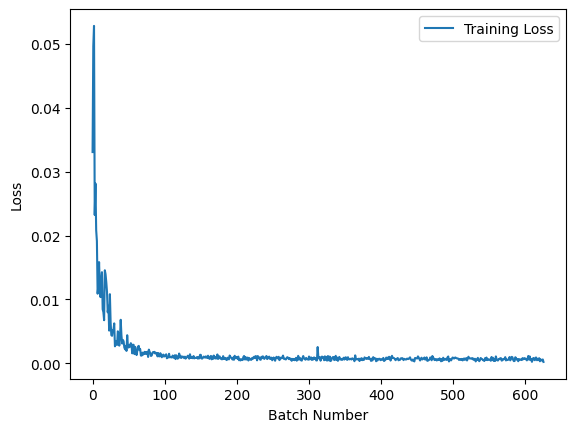

In [ ]:
# Plot loss across a single epoch
import matplotlib.pyplot as plt

plt.plot(losses, label='Training Loss')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate Model
Determine our final MSE, RMSE, and MAE and compare it against other works.

In [ ]:
def denormalize_predictions(predictions):
    """
    Denormalizes predictions by scaling them back to the original
    range of values.
    """
    return predictions * (global_max - global_min) + global_min

In [ ]:
# Predict on test data
model.eval()
test_losses = []
test_losses_denormalized = []
test_loss_sum = 0

with torch.no_grad():
    for batch_idx, (batch_data, batch_labels) in enumerate(test_loader):
        output = model(batch_data)
        loss = loss_fn(output.to(device), batch_labels.float().to(device))
        test_losses.append(loss.item())

        output = denormalize_predictions(output)
        labels = denormalize_predictions(batch_labels)

        loss_denormalized = loss_fn(output.to(device), labels.float().to(device))
        test_losses_denormalized.append(loss_denormalized.item())
        test_loss_sum += loss_denormalized.item()

avg_test_loss = test_loss_sum / len(test_losses)
print(f"Average Test Loss: {avg_test_loss:.4f}")
print(f"Avg RMSE: {math.sqrt(avg_test_loss):.4f}")

Average Test Loss: 26.1729
Avg RMSE: 5.1159


In [ ]:
loss_fn = nn.L1Loss()

In [ ]:
# Predict on test data
model.eval()
test_losses = []
test_losses_denormalized = []
test_loss_sum = 0

with torch.no_grad():
    for batch_idx, (batch_data, batch_labels) in enumerate(test_loader):
        output = model(batch_data)
        loss = loss_fn(output.to(device), batch_labels.float().to(device))
        test_losses.append(loss.item())

        output = denormalize_predictions(output)
        labels = denormalize_predictions(batch_labels)

        loss_denormalized = loss_fn(output.to(device), labels.float().to(device))
        test_losses_denormalized.append(loss_denormalized.item())
        test_loss_sum += loss_denormalized.item()

avg_test_loss = test_loss_sum / len(test_losses)
print(f"Average Test MAE: {avg_test_loss:.4f}")

Average Test MAE: 3.1376
